In [2]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

%matplotlib inline

In [3]:
#Loading data
A = scio.loadmat("tesis_cami/A.mat")["A"]
b = scio.loadmat("tesis_cami/b.mat")["b"]
XDOM = scio.loadmat("tesis_cami/XDOM.mat")["XDOM"]
YDOM = scio.loadmat("tesis_cami/YDOM.mat")["YDOM"]
ZDOM = scio.loadmat("tesis_cami/ZDOM.mat")["ZDOM"]
u = scio.loadmat("tesis_cami/u.mat")["u"]
time = scio.loadmat("tesis_cami/tiempo.mat")["tiempo"]
Su = scio.loadmat("tesis_cami/Su.mat")["Su"]
XDO = scio.loadmat("tesis_cami/XDO.mat")["XDO"]
YDO = scio.loadmat("tesis_cami/YDO.mat")["YDO"]
ZSOL = scio.loadmat("tesis_cami/ZSOL.mat")["ZSOL"]

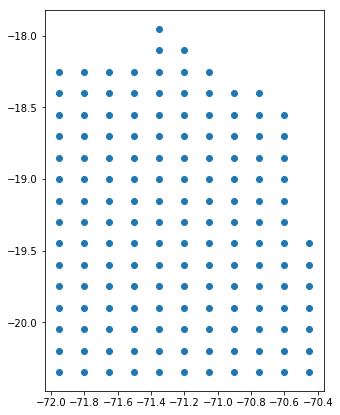

In [4]:
#Source points used
plt.figure(figsize=(5,7))
plt.scatter(u[:,0],u[:,1])

In [5]:
#Splitting data in different sensors
sensors = ["Arica","Iquique", "Patache", "Mejillones", "DART"]
# A: Source time series, b: Tide gate time series for each sensor.
A_arica,b_arica = A[:961],b[:961]
A_iquique,b_iquique = A[961:961*2],b[961:961*2]
A_patache,b_patache = A[961*2:961*3],b[961*2:961*3]
A_mejillones,b_mejillones = A[961*3:961*4],b[961*3:961*4]
A_dart,b_dart = A[961*4:],b[961*4:]

As = [A_arica,A_iquique,A_patache,A_mejillones,A_dart]
bs = [b_arica,b_iquique,b_patache,b_mejillones,b_dart]

#Time when data comes to the sensor
time_offset = np.array([100,80,100,100,50]) #Poner que onda
inversion_time = 50 #

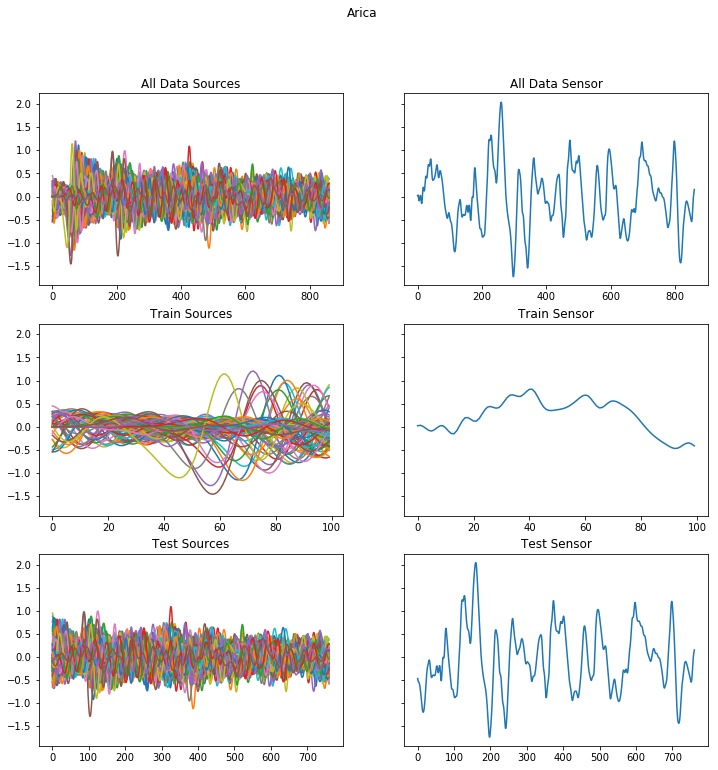

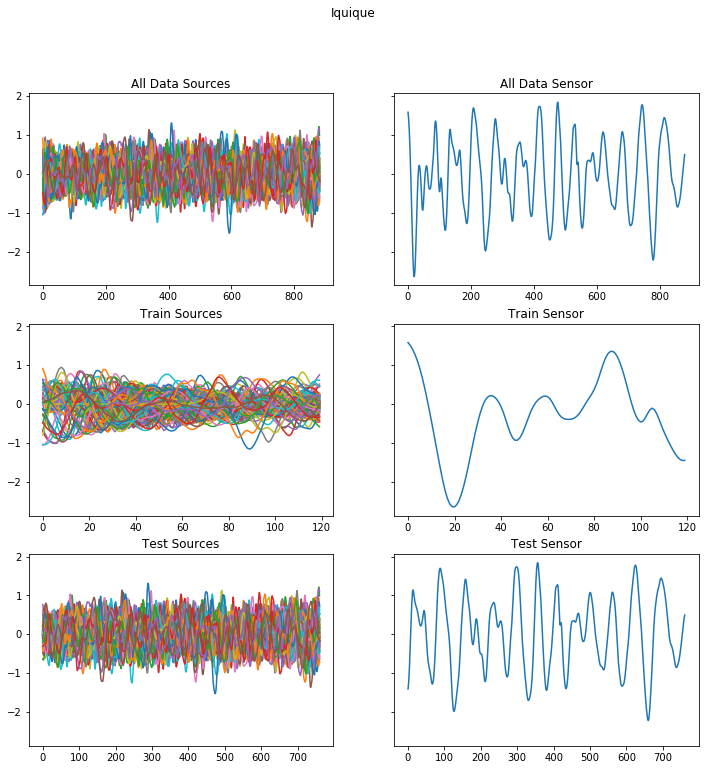

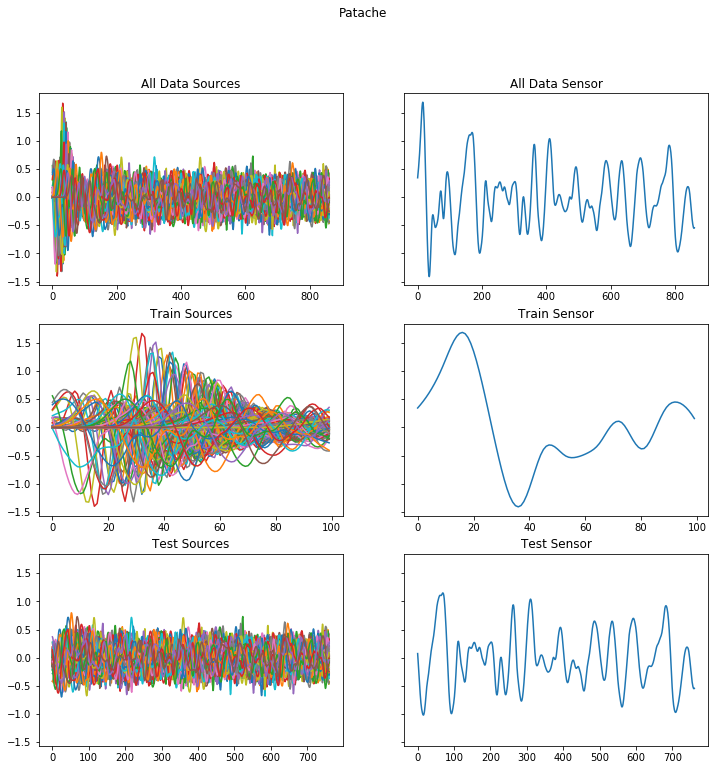

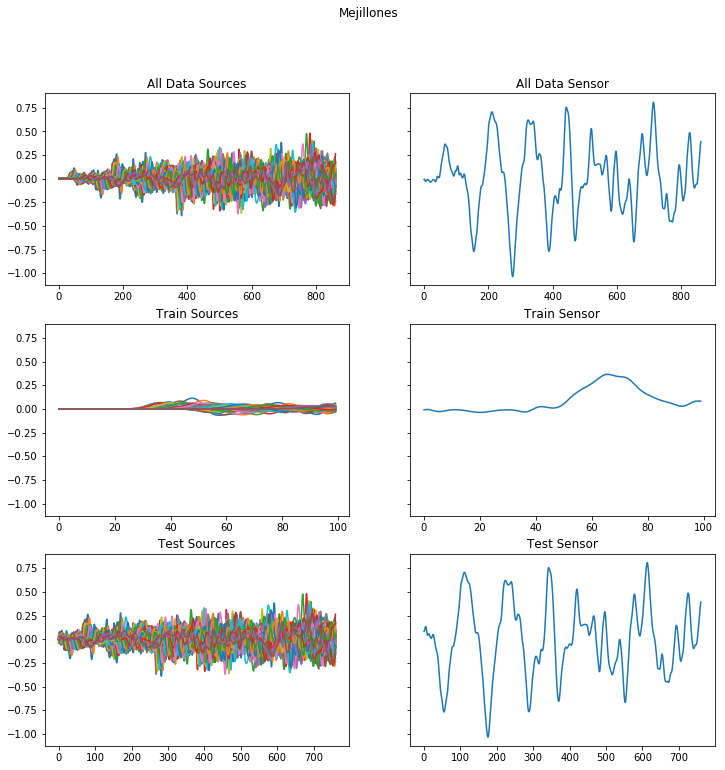

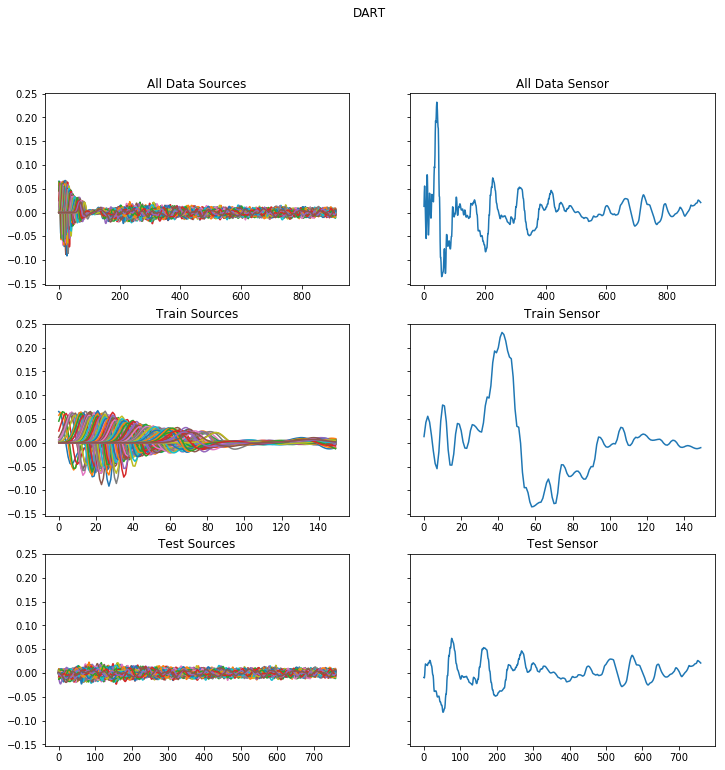

In [6]:
#Stacking all sensor data
AA = []
bb = []

AA_test = []
bb_test = []

for A_i,b_i,title,toffset in zip(As,bs,sensors,time_offset):
    
    #Getting inversion time
    start = toffset
    end = inversion_time*4
    #Separating train with test
    AA.append(A_i[start:end])
    bb.append(b_i[start:end])

    AA_test.append(A_i[end:])
    bb_test.append(b_i[end:])
    
    #Plotting figures
    fig,axes = plt.subplots(3,2,figsize=(12,12),sharey=True)
    axes[0,0].plot(A_i[toffset:,:])
    axes[0,1].plot(b_i[toffset:])
    axes[0,0].set_title("All Data Sources")
    axes[0,1].set_title("All Data Sensor")

    axes[1,0].plot(A_i[start:end])
    axes[1,1].plot(b_i[start:end])
    axes[1,0].set_title("Train Sources")
    axes[1,1].set_title("Train Sensor")

    axes[2,0].plot(A_i[end:])
    axes[2,1].plot(b_i[end:])    
    axes[2,0].set_title("Test Sources")
    axes[2,1].set_title("Test Sensor")
    
    fig.suptitle(title)
    plt.show()
#Stacking all sensor data
AA = np.vstack(AA)
bb = np.vstack(bb)

In [7]:
#Calculating least square solution
reg = Ridge()
reg.fit(AA,bb)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

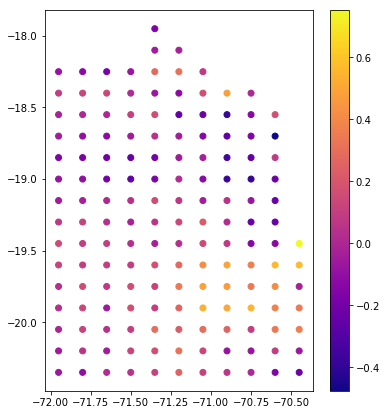

In [10]:
#Source points used
plt.figure(figsize=(6,7))
plt.scatter(u[:,0],u[:,1],c=reg.coef_,cmap="plasma")
plt.colorbar()

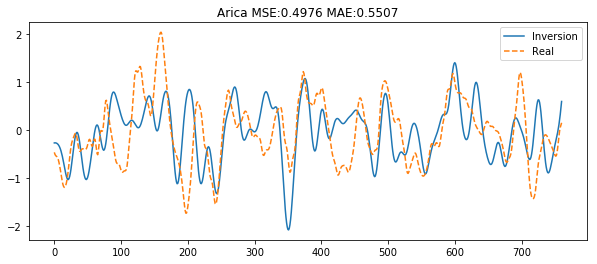

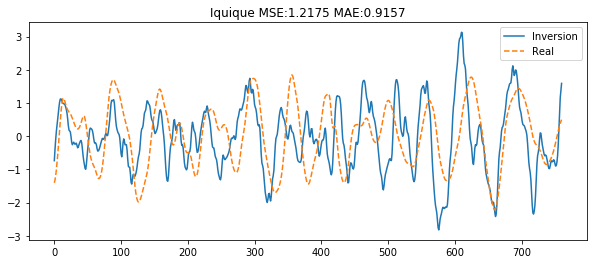

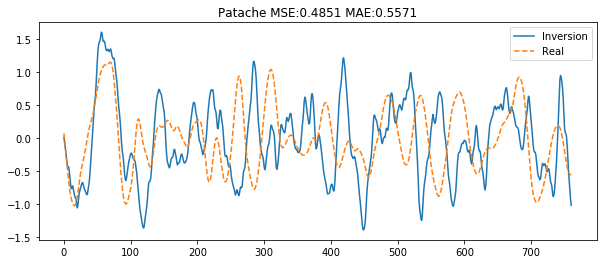

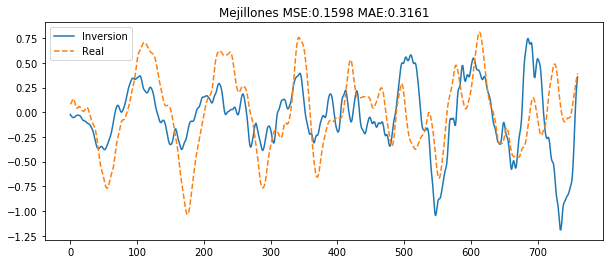

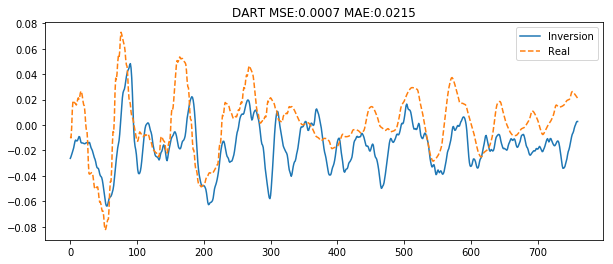

In [11]:
#Plotting solutions with rigde regression
for A_test_i, b_test_i,title in zip(AA_test,bb_test,sensors):
    b_pred = reg.predict(A_test_i)
    MSE = round(metrics.mean_squared_error(b_test_i,b_pred),4)
    MAE = round(metrics.mean_absolute_error(b_test_i,b_pred),4)

    plt.figure(figsize=(10,4))
    plt.title("{} MSE:{} MAE:{}".format(title,MSE, MAE))
    plt.plot(b_pred,label="Inversion")
    plt.plot(b_test_i[:,0],"--",label="Real")
    plt.legend()
    plt.show()